In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras import layers,regularizers,Sequential,Model,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import sys
import json
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
# Import train data, drop sig_id, cp_type

train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
non_ctl_idx = train_features.loc[train_features['cp_type']!='ctl_vehicle'].index.to_list()
train_features = train_features.drop(['sig_id','cp_type','cp_dose','cp_time'],axis=1)
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_scored = train_targets_scored.drop('sig_id',axis=1)
labels_train = train_targets_scored.values

# Drop training data with ctl vehicle

train_features = train_features.iloc[non_ctl_idx]
labels_train = labels_train[non_ctl_idx]

# Import test data

test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
test_features = test_features.drop(['sig_id','cp_dose','cp_time'],axis=1)

# Import predictors from public kernel

json_file_path = '../input/t-test-pca-rfe-logistic-regression/main_predictors.json'

with open(json_file_path, 'r') as j:
    predictors = json.loads(j.read())
    predictors = predictors['start_predictors']

In [3]:
# Create g-mean, c-mean, genes_pca (2 components), cells_pca (all components)

cs = train_features.columns.str.contains('c-')
gs = train_features.columns.str.contains('g-')

def preprocessor(train,test):
    
    # PCA
    
    n_gs = 2 # No of PCA comps to include
    n_cs = 100 # No of PCA comps to include
    
    pca_cs = PCA(n_components = n_cs)
    pca_gs = PCA(n_components = n_gs)

    train_pca_gs = pca_gs.fit_transform(train[:,gs])
    train_pca_cs = pca_cs.fit_transform(train[:,cs])
    test_pca_gs = pca_gs.transform(test[:,gs])
    test_pca_cs = pca_cs.transform(test[:,cs])
    
    # c-mean, g-mean
    
    train_c_mean = train[:,cs].mean(axis=1)
    test_c_mean = test[:,cs].mean(axis=1)
    train_g_mean = train[:,gs].mean(axis=1)
    test_g_mean = test[:,gs].mean(axis=1)
    
    # Append Features
    
    train = np.concatenate((train,train_pca_gs,train_pca_cs,train_c_mean[:,np.newaxis]
                            ,train_g_mean[:,np.newaxis]),axis=1)
    test = np.concatenate((test,test_pca_gs,test_pca_cs,test_c_mean[:,np.newaxis],
                           test_g_mean[:,np.newaxis]),axis=1)
    
    # Scaler for numerical values

    # Scale train data
    scaler = preprocessing.StandardScaler()

    train = scaler.fit_transform(train)

    # Scale Test data
    test = scaler.transform(test)
    
    return train, test


In [4]:
n_labels = train_targets_scored.shape[1]
n_train = train_features.shape[0]
n_test = test_features.shape[0]


# Prediction Clipping Thresholds

p_min = 0.0005
p_max = 0.9995

# OOF Evaluation Metric with clipping and no label smoothing

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [5]:
def build_model(n_features, n_features_2, n_labels, label_smoothing = 0.0005):    
    input_1 = layers.Input(shape = (n_features,), name = 'Input1')
    input_2 = layers.Input(shape = (n_features_2,), name = 'Input2')

    head_1 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(512, activation="elu"), 
        layers.BatchNormalization(),
        layers.Dense(256, activation = "elu")
        ],name='Head1') 

    input_3 = head_1(input_1)
    input_3_concat = layers.Concatenate()([input_2, input_3])

    head_2 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, "relu"),
        layers.BatchNormalization(),
        layers.Dense(512, "elu"),
        layers.BatchNormalization(),
        layers.Dense(256, "relu"),
        layers.BatchNormalization(),
        layers.Dense(256, "elu")
        ],name='Head2')

    input_4 = head_2(input_3_concat)
    input_4_avg = layers.Average()([input_3, input_4]) 

    head_3 = Sequential([
        layers.BatchNormalization(),
        layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, activation="sigmoid")
        ],name='Head3')

    output = head_3(input_4_avg)


    model = Model(inputs = [input_1, input_2], outputs = output)
    model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(label_smoothing=label_smoothing), metrics=logloss)
    
    return model

In [6]:
# Generate Seeds

n_seeds = 7 #7
np.random.seed(1)
seeds = np.random.randint(0,100,size=n_seeds)

# Training Loop

n_folds = 10
y_pred = np.zeros((n_test,n_labels))
oof = tf.constant(0.0)
hists = []
for seed in seeds:
    fold = 0
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=seed)
    for train, test in kf.split(train_features):
        print("FOLDS:", fold, 'seed:', seed)
        
        X_train, X_test = preprocessor(train_features.iloc[train].values,
                                       train_features.iloc[test].values)
        _,data_test = preprocessor(train_features.iloc[train].values,
                                   test_features.drop('cp_type',axis=1).values)
        X_train_2 = train_features.iloc[train][predictors].values
        X_test_2 = train_features.iloc[test][predictors].values
        data_test_2 = test_features[predictors].values
        y_train = labels_train[train]
        y_test = labels_train[test]
        n_features = X_train.shape[1]
        n_features_2 = X_train_2.shape[1]

        model = build_model(n_features, n_features_2, n_labels)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_logloss', factor=0.1, patience=2, mode='min', min_lr=1E-5)
        early_stopping = EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=10, mode='min',restore_best_weights=True)
        
        checkpt = ModelCheckpoint(f'repeat:{seed}_Fold:{fold}.hdf5', monitor = 'val_loss', verbose = 0, 
                              save_best_only = True, mode = 'min')  ##save_weights_only = True,
        

        hist = model.fit([X_train,X_train_2],y_train, batch_size=128, epochs=192,verbose=0,validation_data = ([X_test,X_test_2],y_test),
                         callbacks=[reduce_lr, early_stopping,checkpt])
        hists.append(hist)
        model.load_weights(f'repeat:{seed}_Fold:{fold}.hdf5')
        # Save Model
        #model.save('TwoHeads_seed_'+str(seed)+'_fold_'+str(fold))

        # OOF Score
        y_val = model.predict([X_test,X_test_2])
        oof += logloss(tf.constant(y_test,dtype=tf.float32),tf.constant(y_val,dtype=tf.float32))/(n_folds*n_seeds)

        # Run prediction
        y_pred += model.predict([data_test,data_test_2])/(n_folds*n_seeds)

        fold += 1

FOLDS: 0 seed: 37
FOLDS: 1 seed: 37
FOLDS: 2 seed: 37
FOLDS: 3 seed: 37
FOLDS: 4 seed: 37
FOLDS: 5 seed: 37
FOLDS: 6 seed: 37
FOLDS: 7 seed: 37
FOLDS: 8 seed: 37
FOLDS: 9 seed: 37
FOLDS: 0 seed: 12
FOLDS: 1 seed: 12
FOLDS: 2 seed: 12
FOLDS: 3 seed: 12
FOLDS: 4 seed: 12
FOLDS: 5 seed: 12
FOLDS: 6 seed: 12
FOLDS: 7 seed: 12
FOLDS: 8 seed: 12
FOLDS: 9 seed: 12
FOLDS: 0 seed: 72
FOLDS: 1 seed: 72
FOLDS: 2 seed: 72
FOLDS: 3 seed: 72
FOLDS: 4 seed: 72
FOLDS: 5 seed: 72
FOLDS: 6 seed: 72
FOLDS: 7 seed: 72
FOLDS: 8 seed: 72
FOLDS: 9 seed: 72
FOLDS: 0 seed: 9
FOLDS: 1 seed: 9
FOLDS: 2 seed: 9
FOLDS: 3 seed: 9
FOLDS: 4 seed: 9
FOLDS: 5 seed: 9
FOLDS: 6 seed: 9
FOLDS: 7 seed: 9
FOLDS: 8 seed: 9
FOLDS: 9 seed: 9
FOLDS: 0 seed: 75
FOLDS: 1 seed: 75
FOLDS: 2 seed: 75
FOLDS: 3 seed: 75
FOLDS: 4 seed: 75
FOLDS: 5 seed: 75
FOLDS: 6 seed: 75
FOLDS: 7 seed: 75
FOLDS: 8 seed: 75
FOLDS: 9 seed: 75
FOLDS: 0 seed: 5
FOLDS: 1 seed: 5
FOLDS: 2 seed: 5
FOLDS: 3 seed: 5
FOLDS: 4 seed: 5
FOLDS: 5 seed: 5
FOLDS: 6

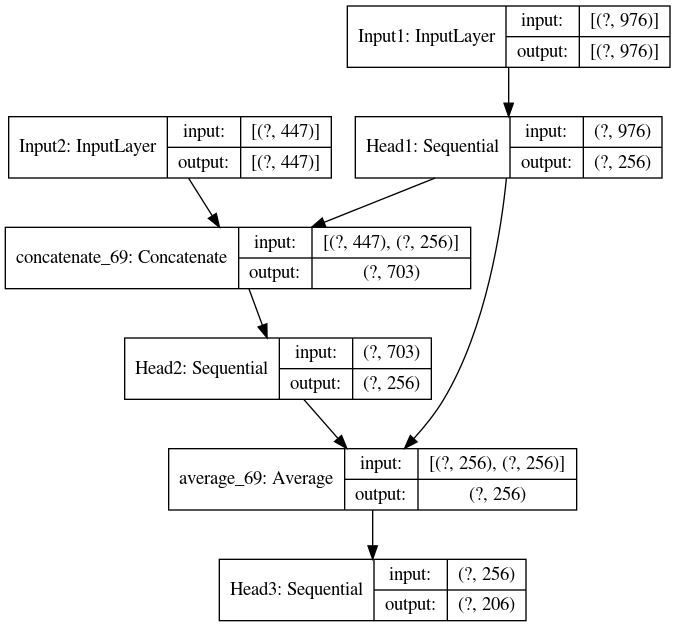

In [7]:
# Model Architecture

tf.keras.utils.plot_model(model,show_shapes=True)

OOF score is  0.0165640805


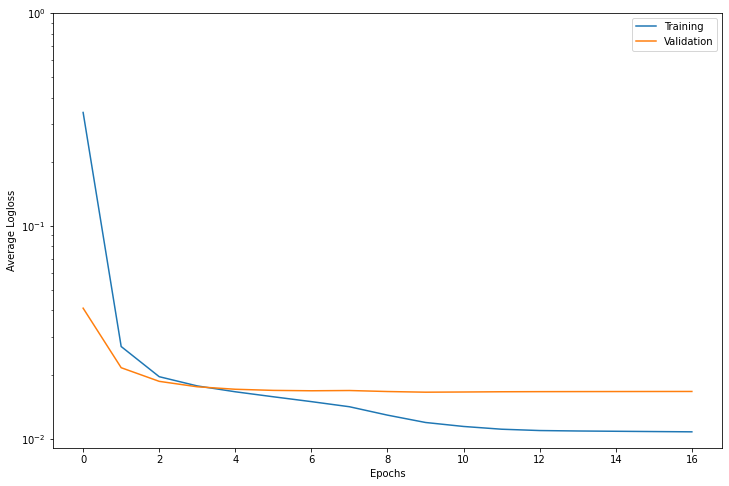

In [8]:
# Analysis of Training

tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_val)

plt.yscale('log')
plt.yticks(ticks=[1,1E-1,1E-2])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [9]:
# Generate submission file, Clip Predictions

sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
sub.iloc[:,1:] = np.clip(y_pred,p_min,p_max)

# Set ctl_vehicle to 0
sub.iloc[test_features['cp_type'] == 'ctl_vehicle',1:] = 0

# Save Submission
sub.to_csv('submission.csv', index=False)